Created by Qing Lan(qlan@nd.edu), July 3rd, 2020

# Advanced First-Order Seccond-Momemt Methods (AFSOM)


## Illustration of figure 8.6 in textbook: 

McClarren, Ryan G (2018). Uncertainty Quantification and Predictive Computational Science: A Foundation for Physical Scientists and Engineers, Chapter 8: Reliability Methods for Estimating the Probability of Failure, https://link.springer.com/chapter/10.1007/978-3-319-99525-0_8

$Q(\mathbf{X}) = 2x_1^3+10x_1 x_2 + x_1 + 3x_2^3+x_2$ 

$x_1 \backsim \mathcal{N} (0.1, 2^2)$ 

$x_2 \backsim \mathcal{N} (-0.05, 3^2)$ 

Covariance matrix $\Sigma = \begin{pmatrix}
4 & 3.9\\
3.9 & 9
\end{pmatrix}$

Correlation matrix $ \mathbf{R} = \begin{pmatrix}
1 & 0.65\\
0.65 & 1
\end{pmatrix}$

In [347]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal

In [348]:
# Define the function for QoI
def QoI(x):
    x1 = x[0].item()
    x2 = x[1].item()
    return 2*x1**3 + 10*x1*x2 + x1 + 3*x2**3 + x2 # a scalar

# Derivatives of QoI with respect to X
def DQ_DX(x):
    x1 = x[0].item()
    x2 = x[1].item()
    dQ_dx1 = 6*x1**2 + 10*x2 + 1
    dQ_dx2 = 10*x1 + 9*x2**2 + 1
    return  np.array([[dQ_dx1, dQ_dx2]]) # a 2-D column array


Standardize the coordinate system:

$Y_i = \frac{x_i-\mu_i'}{\sigma_i'}$

so that

$Y_i \backsim \mathcal{N} (0, 1)$

with known correlation matrix $\mathbf{R}$ (unchanged)


In [349]:
# Derivatives of QoI to Y using chain rule
def DQ_DY(x):
    x1 = x[0].item()
    x2 = x[1].item()
    dQ_dy1 = 12*x1**2 + 20*x2 + 2
    dQ_dy2 = 30*x1 + 27*x2**2 + 3
    return np.array([[dQ_dy1, dQ_dy2]]) # a 2-D column array

Failure surface:

$Z = Q_{fail}-Q{(\mathbf{X})} = 0$ 

We seek for finding the nearest point on the failure surface to the nominal value, which means minimizing

$\beta = \underset{Z(\mathbf{X})=0}{\text{min}} \sqrt{\mathbf{Y^T(X)R^{-1}Y(X)}}$

With Lagrange multiplier method in Eq.8.11, we get

$\beta = \frac{Q_{fail}-Q(\mathbf{X})+\nabla_\mathbf{Y}QY} {\sqrt{\nabla_\mathbf{Y}Q \mathbf{R} \nabla_\mathbf{Y}^{T}Q}}$



In [413]:
def AFOSM(x0, pdf_x, cdf_x, R, Q_fail, delta, eps, max_steps):
    
    '''
        x0: initial guess
        pdf_x: list of margin PDF functions of variables in x
        cdf_x: list of margin CDF functions of variables in x
        R: correlation matrix of x
        Q_fail: failure threshold
        delta: tolerance of convergence of beta
        eps: tolerance of convergence of abs(Q-Q_fail)
        
    '''
    
    
    
    def solv_y (xl, pdf_x, cdf_x):
        # a function that finds standardized variable y and the corresponding mu_y and sigma_y
        # based on the fact that CDF and PDF at ccorresponding points should be the same as the originals
        
        '''
        inputs: x, mu_x, sigma_x
        outputs: yi=(xi-mu_xi), mu_y, sigma_y
        '''
        
        # get dimension of inputs
        dim = len(x0)
        
        # initialize new variable Y, mu_y and sigma_y
        yl = x0*0
        sigma_y = x0*0
        mu_y = x0*0
        
        # solve for mu_y and sigma_y
        for i in range(dim):
            xi = xl[i].item()
            
            # get the distribution functions from the list
            fun_pdf = pdf_x[i]
            fun_cdf = cdf_x[i]
            # cumulative distribution function value at x_i
            cdf_xi = fun_cdf(xi)
            # probability distribution function value at x_i
            pdf_xi = fun_pdf(xi)
            
            # solution for mu and sigma of yi, using the formula Eq.8.8 and 8.9
            sigma_yi = norm.pdf(norm.ppf(cdf_xi))/pdf_xi
            mu_yi = xi-norm.ppf(cdf_xi)*sigma_yi

            # save the solution into arrays
            sigma_y[i] = sigma_yi 
            mu_y[i] = mu_yi
            # standardized coordinate
            yl[i] = (xi-mu_yi)/sigma_yi
            
        return yl, mu_y, sigma_y
    

    
    # start up with the first two steps
    
    # collect steps
    beta = []
    xl_lst = []
    # initial step
    l=0
    xl = x0
    xl_lst.append(x0)
    # solve for yl from the current xl
    yl, mu_y, sigma_y = solv_y (xl, pdf_x, cdf_x)
    beta1 = np.sqrt((yl.T@np.linalg.inv(R)@yl).item())
    # Lagrange mutiplier
    lamda = (Q_fail - QoI(xl) + (DQ_DY(xl)@yl).item())/(DQ_DY(xl)@R@DQ_DY(xl).T).item()
    beta.append(beta1)
    
    # second step
    l = l+1
    # update yl, beta2
    yl = lamda*R@(DQ_DY(xl).T)
    beta2 = np.sqrt((yl.T@np.linalg.inv(R)@yl).item())
    beta.append(beta2)
    # update xl
    xl = sigma_y*yl + mu_y
    xl_lst.append(xl)
    
    # iterate until convergence
    while l<max_steps and abs(beta2-beta1)>=delta and abs(QoI(xl)-Q_fail)>=eps:
        # update beta1
        beta1 = beta2
        # solve for yl from the current xl
        yl, mu_y, sigma_y = solv_y (xl, pdf_x, cdf_x)
        # Lagrange mutiplier
        lamda = (Q_fail - QoI(xl) + DQ_DY(xl)@yl)/(DQ_DY(xl)@R@DQ_DY(xl).T)
        
        # update yl and beta
        yl = lamda*R@DQ_DY(xl).T
        beta2 = np.sqrt((yl.T@np.linalg.inv(R)@yl).item())
        
        # update xl
        xl = sigma_y*yl + mu_y
        xl_lst.append(xl)

        beta.append(beta2)
        l = l+1

    return beta2.item(), beta, xl_lst, l
        

In [414]:
# implement

# known parameters
x0 = np.array([[2.5], [2.]]) # initial guess
mu = np.array([[0.1], [-0.05]])
sigma = np.array([[2.0], [3.0]])
co_var = np.array([[4, 3.9], [3.9, 9]])
R = np.array([[1.0, 0.65], [0.65, 1.0]])

# PDF and CDF of x1, x2
pdf_x1 = lambda x1: norm.pdf(x1, loc=mu[0], scale=sigma[0]);
cdf_x1 = lambda x1: norm.cdf(x1, loc=mu[0], scale=sigma[0]);
pdf_x2 = lambda x2: norm.pdf(x2, loc=mu[1], scale=sigma[1]);
cdf_x2 = lambda x2: norm.cdf(x2, loc=mu[1], scale=sigma[1]);
pdf_x = [pdf_x1, pdf_x2]
cdf_x = [cdf_x1, cdf_x2]

# failure threshold
Q_fail = 100

# limitations of the loop
max_steps = 1000
delta = 1e-5
eps = 1e-5

betal, beta, xl_lst, total_steps = AFOSM(x0, pdf_x, cdf_x, R, Q_fail, delta, eps, max_steps)

print('Total steps:', total_steps)
print('Found beta=', betal)
print('beta^2=', betal**2)

Total steps: 4
Found beta= 0.889313478524262
beta^2= 0.790878463084923
[array([[2.5],
       [2. ]]), array([[1.70152124],
       [2.59614528]]), array([[1.53138386],
       [2.55451522]]), array([[1.5216777 ],
       [2.55448122]]), array([[1.52110838],
       [2.55477684]])]


$\beta$ defines an ellipse:

$(\mathbf{X-\mu})^T\Sigma^{-1}\mathbf{X-\mu}=\beta^2$


Text(0.5, 1.0, 'Reproducing fig. 8.6')

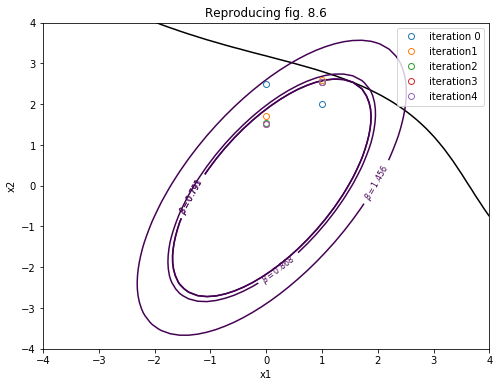

In [421]:
x1 = np.linspace(-4, 4, 50)
x2 = np.linspace(-4, 4, 50)
X, Y = np.meshgrid(x1, x2)


def fail_surf(x1, x2):
    return 2*x1**3 + 10*x1*x2 + x1 + 3*x2**3 + x2 - 100.
    
def ellipse(x1, x2, beta):
    x = [[x1], [x2]]
    return (x-mu).T@np.linalg.inv(co_var)@(x-mu)-beta**2


# vetorize functions so as to apply elementwise on arrays
vec_fail = np.vectorize(fail_surf)
vec_ellip = np.vectorize(ellipse)

# failure surface
fail_Z = vec_fail(X, Y)
# ellipse
Z = vec_ellip(X, Y, betal)


# make the graph
fig, ax = plt.subplots(figsize=(8, 6))

# contour failure surface
ax.contour(X, Y, fail_Z, [0], colors='black', )

# plot iterations
ax.plot(xl_lst[0], 'o', fillstyle='none', label='iteration 0') # initial guess
for i in range(total_steps):
    # iteration i
    ax.plot(xl_lst[i+1], 'o', fillstyle='none', label='iteration%d'%(i+1))
    # contour ellipse
    CS = ax.contour(X, Y, vec_ellip(X, Y, beta[i]),[0])
    ax.clabel(CS, CS.levels, fmt=r'$\beta=%.3f$'%beta[i]**2, fontsize=8)
plt.legend()

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Reproducing fig. 8.6')
